/tmp/ipykernel_153330/2390918524.py:59: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lon = datasets['historical'].dims['lon']


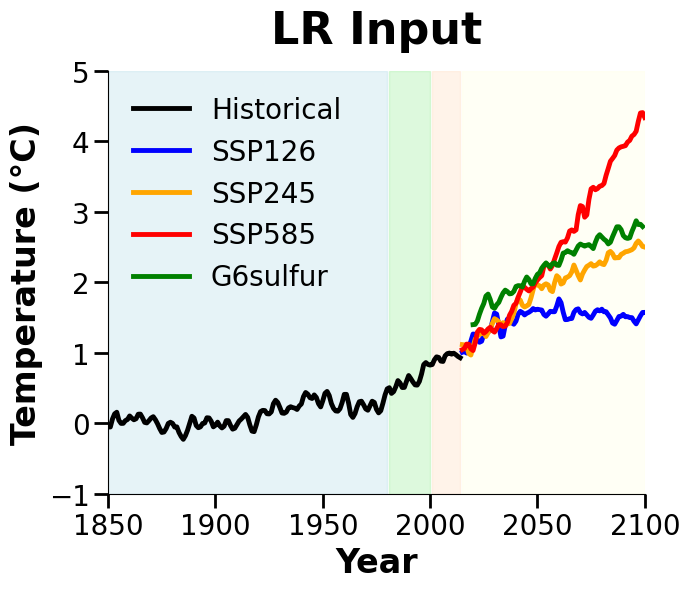

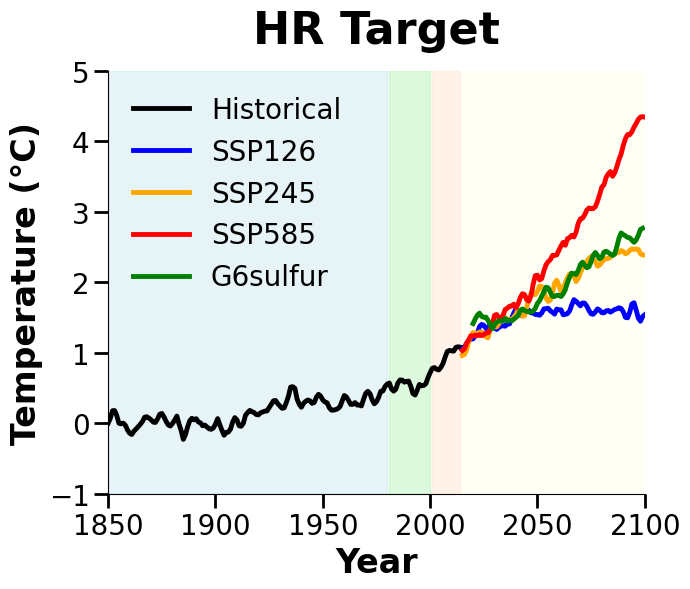

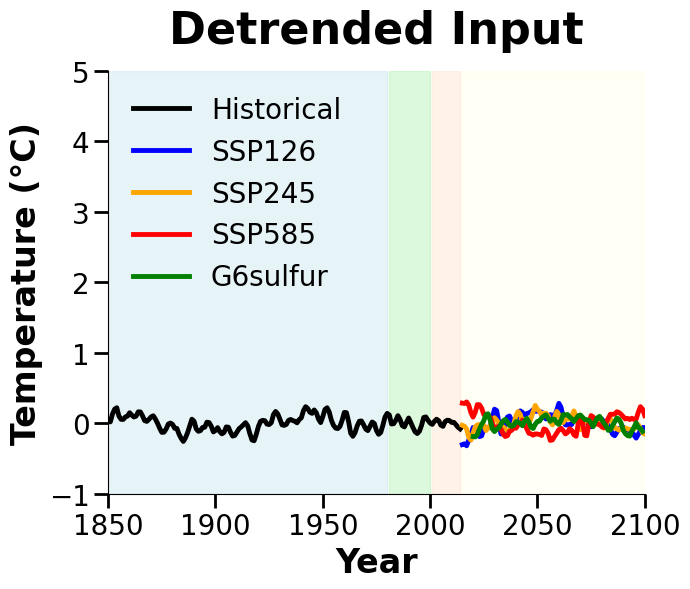

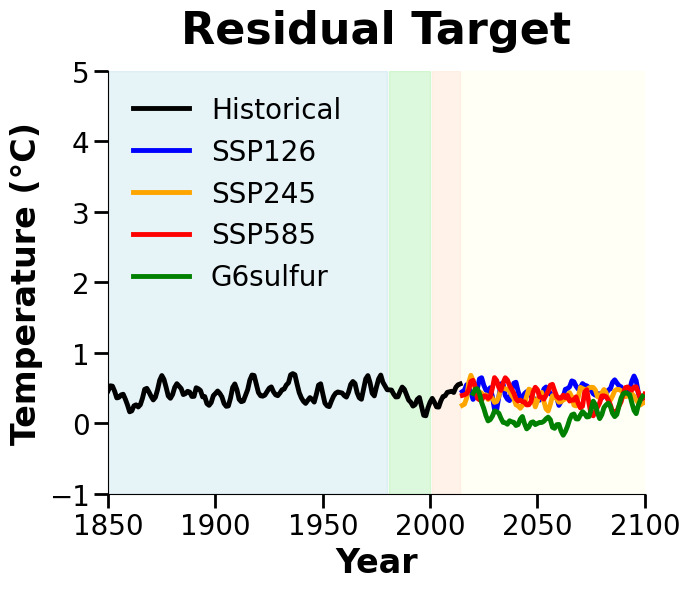

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load datasets once
datasets = {
    'historical': xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc"),
    'ssp126': xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc"),
    'ssp245': xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc"),
    'ssp585': xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc"),
    'g6sulfur': xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc"),
}

scenario_order = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']

colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'green'
}

labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

time_periods_detrend = [
    (1850, 1980),
    (1981, 2000),
    (2001, 2014),
    (2015, 2100)
]

# ----------------------------
# Latitude weights
# ----------------------------
lats = datasets['historical']['lat'].values
n_lon = datasets['historical'].dims['lon']
lat_weights_2d = np.cos(np.deg2rad(lats))[:, np.newaxis] * np.ones((1, n_lon))
w_total = np.sum(lat_weights_2d)

# ----------------------------
# Helper functions
# ----------------------------
def weighted_global_mean(data_3d):
    return np.sum(data_3d * lat_weights_2d[np.newaxis, :, :], axis=(1, 2)) / w_total

def weighted_baseline(data_3d):
    return np.sum(data_3d * lat_weights_2d[np.newaxis, :, :]) / (data_3d.shape[0] * w_total)

def to_annual_mean(data, years):
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    return pd.Series(data).rolling(window=window, center=True, min_periods=1).mean().values

def pointwise_linear_detrend(data_3d, years, time_periods):
    n_time, n_lat, n_lon = data_3d.shape
    detrended = np.zeros_like(data_3d)
    
    for start_year, end_year in time_periods:
        mask = (years >= start_year) & (years <= end_year)
        if not np.any(mask):
            continue
        
        period_data = data_3d[mask]
        n_t = period_data.shape[0]
        t = np.arange(n_t, dtype=float)
        data_flat = period_data.reshape(n_t, -1)
        
        t_mean = np.mean(t)
        data_mean = np.mean(data_flat, axis=0)
        t_centered = t - t_mean
        
        b = np.sum(t_centered[:, np.newaxis] * (data_flat - data_mean), axis=0) / np.sum(t_centered**2)
        a = data_mean - b * t_mean
        trend = a[np.newaxis, :] + b[np.newaxis, :] * t[:, np.newaxis]
        
        detrended[mask] = (data_flat - trend).reshape(n_t, n_lat, n_lon)
    
    return detrended

# ----------------------------
# Data functions for each panel
# ----------------------------
def get_lr_anomaly(ds, baseline):
    return weighted_global_mean(ds['tas_lr_interp'].values) - baseline

def get_hr_anomaly(ds, baseline):
    return weighted_global_mean(ds['tas_hr'].values) - baseline

def get_lr_detrended(ds, baseline):
    data = ds['tas_lr_interp'].values
    years = ds.time.dt.year.values
    detrended = pointwise_linear_detrend(data - baseline, years, time_periods_detrend)
    return weighted_global_mean(detrended)

def get_residual(ds, _baseline):
    return weighted_global_mean(ds['tas_hr'].values - ds['tas_lr_interp'].values)

# ----------------------------
# Calculate baselines
# ----------------------------
hist_ds = datasets['historical']
years_hist = hist_ds.time.dt.year.values
mask_bl = (years_hist >= 1850) & (years_hist <= 1900)

baseline_lr = weighted_baseline(hist_ds['tas_lr_interp'].isel(time=mask_bl).values)
baseline_hr = weighted_baseline(hist_ds['tas_hr'].isel(time=mask_bl).values)

# ----------------------------
# Panel definitions
# ----------------------------
panels = [
    ('LR Input', get_lr_anomaly, baseline_lr, 'fig1_01.png'),
    ('HR Target', get_hr_anomaly, baseline_hr, 'fig1_02.png'),
    ('Detrended Input', get_lr_detrended, baseline_lr, 'fig1_03.png'),
    ('Residual Target', get_residual, None, 'fig1_04.png'),
]

# ----------------------------
# Plot each panel separately
# ----------------------------
for title, data_func, baseline, filename in panels:
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    for scenario_name in scenario_order:
        ds = datasets[scenario_name]
        years = ds.time.dt.year.values
        
        gmean = data_func(ds, baseline)
        annual_years, annual_mean = to_annual_mean(gmean, years)
        smoothed = smooth_data(annual_mean, window=3)
        
        ax.plot(annual_years, smoothed, color=colors[scenario_name],
                linewidth=3.5, alpha=1, label=labels[scenario_name])
    
    for start_year, end_year, color_shade, alpha in shade_periods:
        ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)
    
    ax.set_ylim(-1, 5)
    ax.set_yticks(np.arange(-1, 6, 1))
    ax.set_xlim(1850, 2100)
    ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100])
    ax.set_ylabel('Temperature (°C)', fontsize=24, fontweight='bold',)
    ax.set_xlabel('Year', fontsize=24, fontweight='bold',)
    ax.set_title(title, fontsize=32, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=20, frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=20, length=10, width=2)
    
    plt.tight_layout()
    plt.savefig(figures_dir / filename, dpi=300, bbox_inches='tight')
    plt.show()

# Close datasets
for ds in datasets.values():
    ds.close()

Processing: LR Input


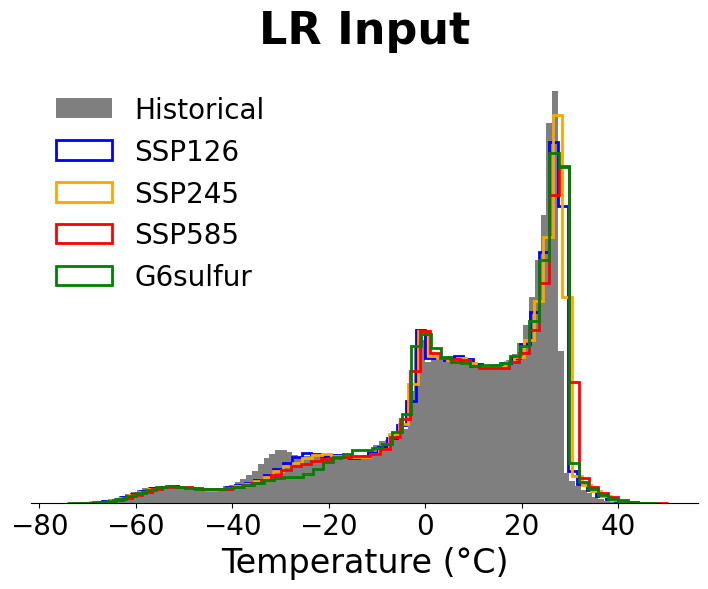

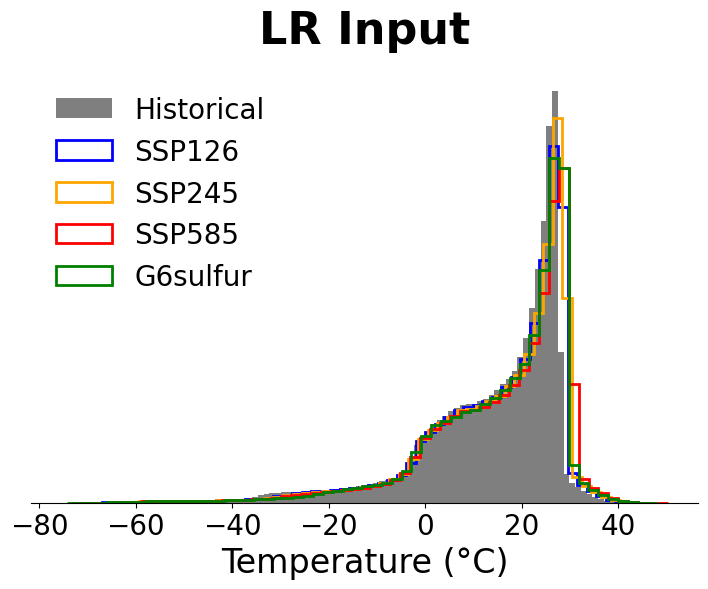

Processing: HR Target


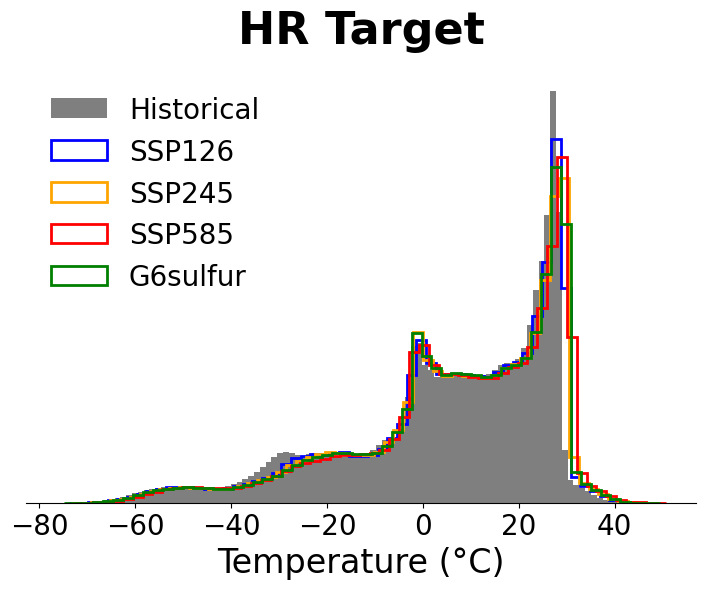

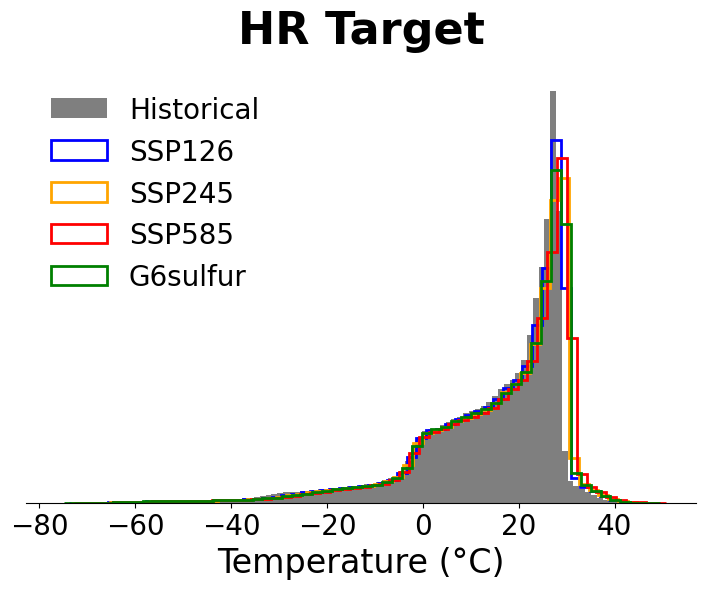

Processing: Detrended Input


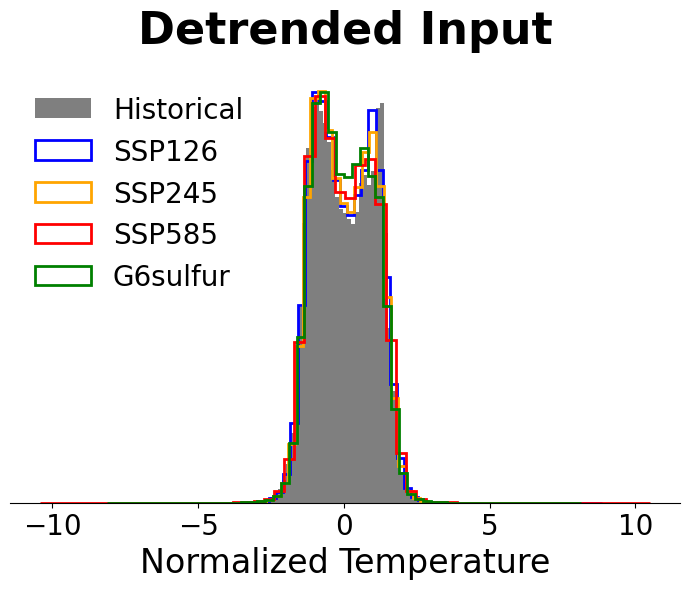

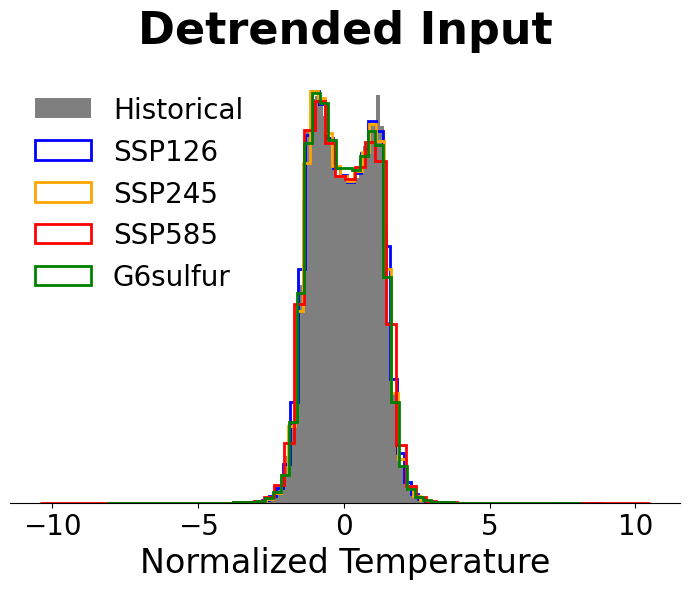

Processing: Residual Target


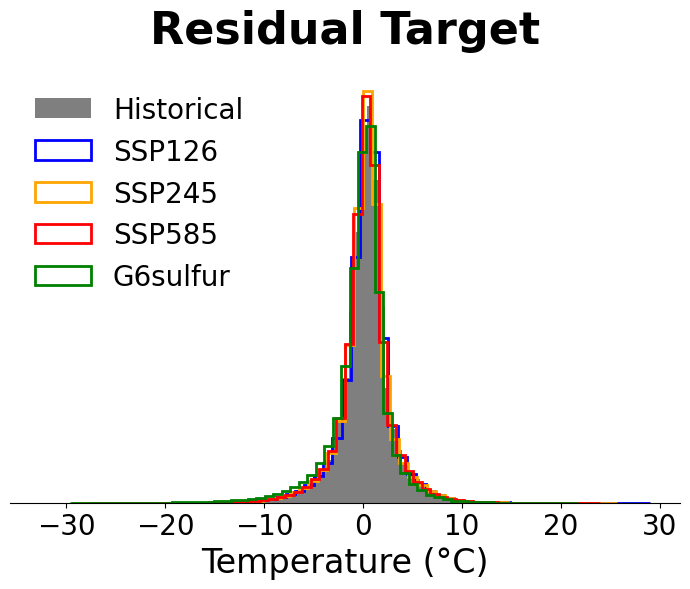

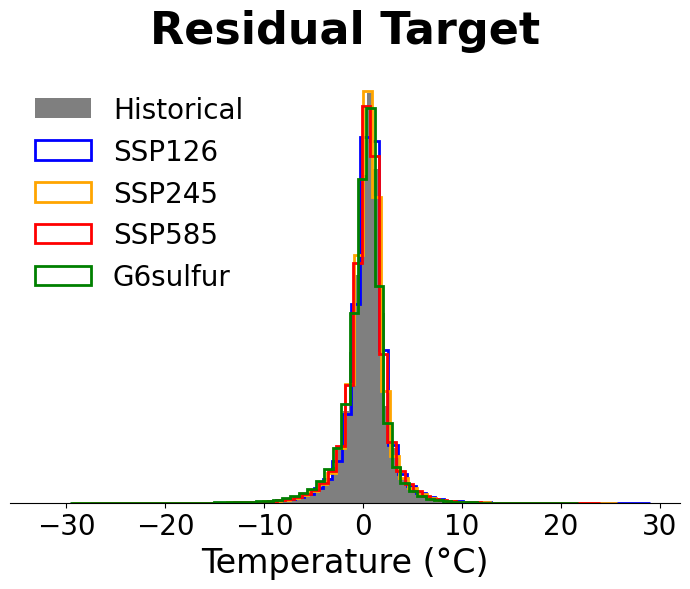

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

# ----------------------------
# Configuration
# ----------------------------
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

train_start = '1850'
train_end = '1980'

colors = {
    'Historical': 'black',
    'SSP126': 'blue',
    'SSP245': 'orange',
    'SSP585': 'red',
    'G6sulfur': 'green',
}

scenario_order = ['SSP126', 'SSP245', 'SSP585', 'G6sulfur']
all_scenarios = ['Historical'] + scenario_order

file_map = {
    'Historical': "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc",
    'SSP126': "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc",
    'SSP245': "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc",
    'SSP585': "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc",
    'G6sulfur': "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc",
}

file_map_detrend = {
    'Historical': "MPI-ESM1-2-HR-LR_historical_residual_detrended.nc",
    'SSP126': "MPI-ESM1-2-HR-LR_ssp126_residual_detrended.nc",
    'SSP245': "MPI-ESM1-2-HR-LR_ssp245_residual_detrended.nc",
    'SSP585': "MPI-ESM1-2-HR-LR_ssp585_residual_detrended.nc",
    'G6sulfur': "MPI-ESM1-2-HR-LR_g6sulfur_residual_detrended.nc",
}

# Load normalization stats once
with open(data_dir / "norm_stats_zscore_pixel_residual_detrended.pkl", 'rb') as f:
    norm_stats_detrend = pickle.load(f)

# ----------------------------
# Data extraction
# ----------------------------
def extract_vals(name, panel_type):
    """Load data and return (values, weights) flattened and filtered."""
    if panel_type == 'lr_detrended':
        ds = xr.open_dataset(data_dir / file_map_detrend[name])
        lats = ds['lat'].values
        data = ds['tas_lr_detrend_grid']
        if name == 'Historical':
            data = data.sel(time=slice(train_start, train_end))
        data_mean = norm_stats_detrend['tas']['lr_detrend_grid']['pixel_mean']
        data_std = norm_stats_detrend['tas']['lr_detrend_grid']['pixel_std']
        data_vals = ((data - data_mean) / (data_std + 1e-8)).values
        ds.close()
    else:
        ds = xr.open_dataset(data_dir / file_map[name])
        lats = ds['lat'].values
        if panel_type == 'lr':
            data = ds['tas_lr_interp']
        elif panel_type == 'hr':
            data = ds['tas_hr']
        elif panel_type == 'residual':
            data = ds['tas_hr'] - ds['tas_lr_interp']
        if name == 'Historical':
            data = data.sel(time=slice(train_start, train_end))
        data_vals = data.values
        ds.close()
    
    cos_weights = np.cos(np.deg2rad(lats))
    weights_3d = np.broadcast_to(cos_weights[np.newaxis, :, np.newaxis], data_vals.shape)
    
    vals_flat = data_vals.ravel()
    weights_flat = weights_3d.ravel()
    
    mask = np.isfinite(vals_flat)
    return vals_flat[mask], weights_flat[mask]

# ----------------------------
# Plotting function
# ----------------------------
def plot_distribution(vals_dict, weights_dict, title, xlabel, filename_uw, filename_w):
    for weighted, filename in [(False, filename_uw), (True, filename_w)]:
        fig, ax = plt.subplots(1, 1, figsize=(7, 6))
        
        w_hist = weights_dict['Historical'] if weighted else None
        ax.hist(vals_dict['Historical'], bins=100, density=True, alpha=0.5,
                color=colors['Historical'], label='Historical', edgecolor='none',
                weights=w_hist)
        
        for name in scenario_order:
            w = weights_dict[name] if weighted else None
            ax.hist(vals_dict[name], bins=60, density=True, histtype='step',
                    linewidth=2, label=name, color=colors[name], weights=w)
        
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(xlabel, fontsize=24)
        
        ax.set_title(f'{title}', fontsize=32, fontweight='bold', pad=20)
        ax.legend(frameon=False, fontsize=20, loc='upper left')
        ax.tick_params(axis='x', which='major', labelsize=20)
        
        plt.tight_layout()
        plt.savefig(figures_dir / filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

# ----------------------------
# Panel configs
# ----------------------------
panel_configs = [
    ('lr', 'LR Input', 'Temperature (°C)', 'fig1_05.png', 'fig1_05_weighted.png'),
    ('hr', 'HR Target', 'Temperature (°C)', 'fig1_06.png', 'fig1_06_weighted.png'),
    ('lr_detrended', 'Detrended Input', 'Normalized Temperature', 'fig1_07.png', 'fig1_07_weighted.png'),
    ('residual', 'Residual Target', 'Temperature (°C)', 'fig1_08.png', 'fig1_08_weighted.png'),
]

# ----------------------------
# Process one panel at a time to control memory
# ----------------------------
for panel_type, title, xlabel, fn_uw, fn_w in panel_configs:
    print(f"Processing: {title}")
    
    vals_dict = {}
    weights_dict = {}
    for name in all_scenarios:
        vals, weights = extract_vals(name, panel_type)
        vals_dict[name] = vals
        weights_dict[name] = weights
    
    plot_distribution(vals_dict, weights_dict, title, xlabel, fn_uw, fn_w)
    
    # Free memory
    del vals_dict, weights_dict

# old

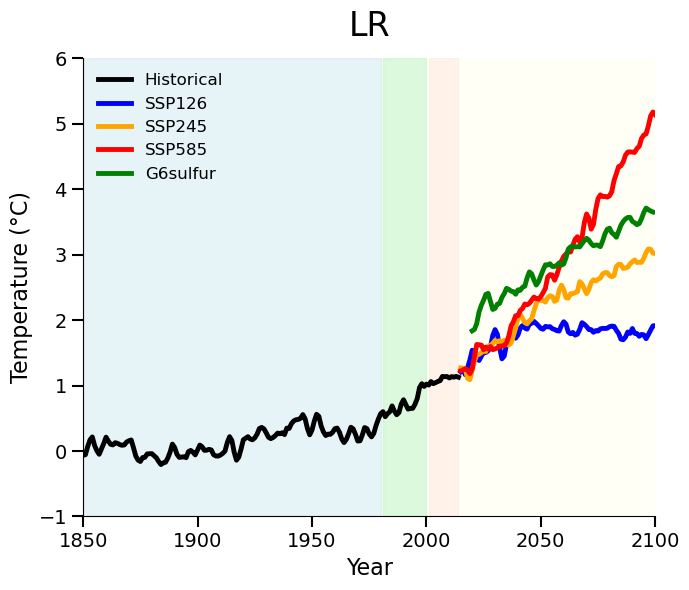

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for shading
shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variable for LR
var_lr = 'tas_lr_interp'

# Calculate baseline (1850-1900) using LR data
baseline_start, baseline_end = 1850, 1900
tas_hist_lr = ds_hist[var_lr]
years_hist = ds_hist.time.dt.year
mask_baseline = (years_hist >= baseline_start) & (years_hist <= baseline_end)
baseline_data = tas_hist_lr.isel(time=mask_baseline)
baseline = baseline_data.mean(dim=['time', 'lat', 'lon']).values

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Colors for scenarios
colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'green'
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

# Reorder scenarios so G6sulfur is last
scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('ssp585', ds_ssp585),
    ('g6sulfur', ds_g6sulfur)
]

for scenario_name, ds in scenarios:
    # Get LR temperature data
    tas_lr_data = ds[var_lr].values
    years = ds.time.dt.year.values
    
    # Calculate LR anomalies
    lr_anomaly_data = tas_lr_data - baseline
    
    # Calculate global mean
    global_mean_lr_anomaly = np.mean(lr_anomaly_data, axis=(1, 2))
    
    # Convert to annual averages
    annual_years, annual_mean = to_annual_mean(global_mean_lr_anomaly, years)
    
    # Apply smoothing
    window = 3
    smoothed = smooth_data(annual_mean, window)
    
    color = colors[scenario_name]
    
    # Plot LR GMST anomaly
    ax.plot(annual_years, smoothed, color=color,
            linewidth=3.5, alpha=1, label=labels[scenario_name])

# Add shading
for start_year, end_year, color_shade, alpha in shade_periods:
    ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)

# Set limits and ticks
ax.set_ylim(-1, 6)
ax.set_yticks(np.arange(-1, 7, 1))
ax.set_xlim(1850, 2100)
ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100])

# Labels
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_title('LR', fontsize=24, pad=16)

# Legend
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick parameters
ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_01.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

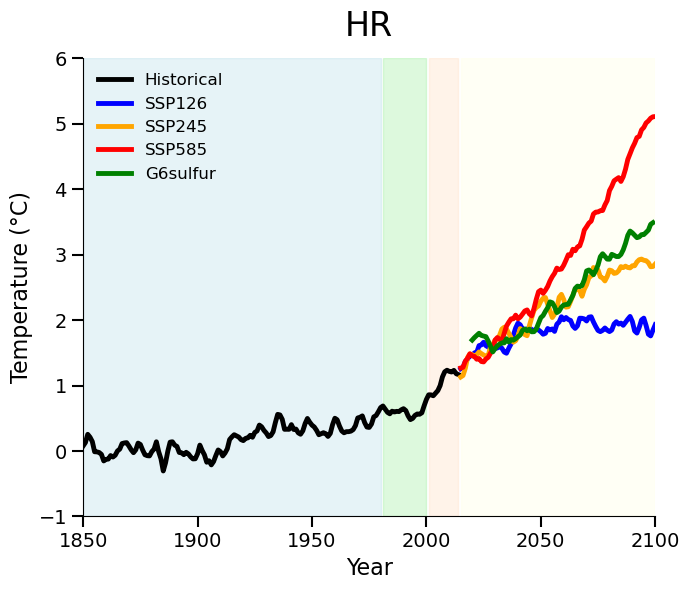

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for shading
shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variable for HR
var_hr = 'tas_hr'

# Calculate baseline (1850-1900) using HR data
baseline_start, baseline_end = 1850, 1900
tas_hist_hr = ds_hist[var_hr]
years_hist = ds_hist.time.dt.year
mask_baseline = (years_hist >= baseline_start) & (years_hist <= baseline_end)
baseline_data = tas_hist_hr.isel(time=mask_baseline)
baseline = baseline_data.mean(dim=['time', 'lat', 'lon']).values

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Colors for scenarios
colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'green'
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

# Reorder scenarios so G6sulfur is last
scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('ssp585', ds_ssp585),
    ('g6sulfur', ds_g6sulfur)
]

for scenario_name, ds in scenarios:
    # Get HR temperature data
    tas_hr_data = ds[var_hr].values
    years = ds.time.dt.year.values
    
    # Calculate HR anomalies
    hr_anomaly_data = tas_hr_data - baseline
    
    # Calculate global mean
    global_mean_hr_anomaly = np.mean(hr_anomaly_data, axis=(1, 2))
    
    # Convert to annual averages
    annual_years, annual_mean = to_annual_mean(global_mean_hr_anomaly, years)
    
    # Apply smoothing
    window = 3
    smoothed = smooth_data(annual_mean, window)
    
    color = colors[scenario_name]
    
    # Plot HR GMST anomaly
    ax.plot(annual_years, smoothed, color=color,
            linewidth=3.5, alpha=1, label=labels[scenario_name])

# Add shading
for start_year, end_year, color_shade, alpha in shade_periods:
    ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)

# Set limits and ticks
ax.set_ylim(-1, 6)
ax.set_yticks(np.arange(-1, 7, 1))
ax.set_xlim(1850, 2100)
ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100])

# Labels
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_title('HR', fontsize=24, pad=16)

# Legend
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick parameters
ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_02.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

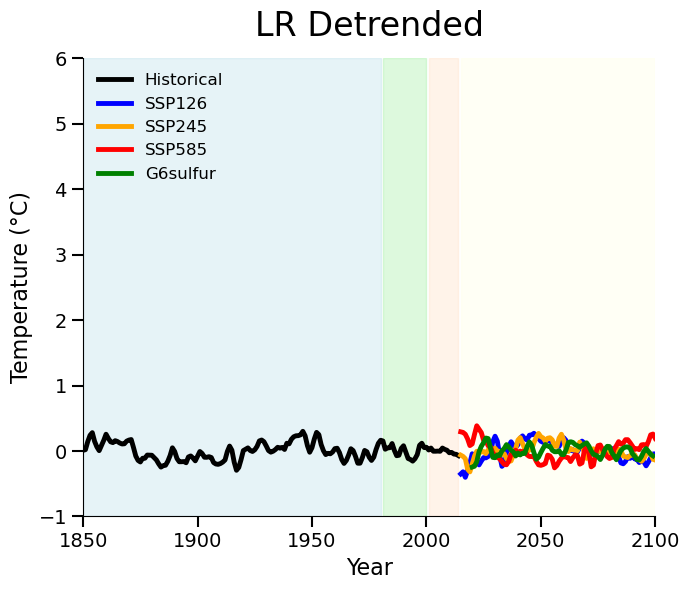

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for detrending
time_periods = [
    (1850, 1980),
    (1981, 2000),
    (2001, 2014),
    (2015, 2100)
]

# Define time periods for shading
shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

def pointwise_linear_detrend(data_3d, years, time_periods):
    """Pointwise Linear Detrend (PLD)"""
    n_time, n_lat, n_lon = data_3d.shape
    detrended_data = np.zeros_like(data_3d)
    fitted_trends = np.zeros_like(data_3d)
    
    for start_year, end_year in time_periods:
        mask = (years >= start_year) & (years <= end_year)
        time_indices = np.where(mask)[0]
        
        if len(time_indices) == 0:
            continue
        
        period_data = data_3d[mask, :, :]
        n_time_period = period_data.shape[0]
        t = np.arange(n_time_period).astype(float)
        data_reshaped = period_data.reshape(n_time_period, -1)
        
        t_mean = np.mean(t)
        data_mean = np.mean(data_reshaped, axis=0)
        
        t_centered = t - t_mean
        data_centered = data_reshaped - data_mean
        
        numerator = np.sum(t_centered[:, np.newaxis] * data_centered, axis=0)
        denominator = np.sum(t_centered**2)
        
        b = numerator / denominator
        a = data_mean - b * t_mean
        
        trend = a[np.newaxis, :] + b[np.newaxis, :] * t[:, np.newaxis]
        residuals = data_reshaped - trend
        
        residuals_3d = residuals.reshape(n_time_period, n_lat, n_lon)
        trend_3d = trend.reshape(n_time_period, n_lat, n_lon)
        
        detrended_data[mask, :, :] = residuals_3d
        fitted_trends[mask, :, :] = trend_3d
    
    return detrended_data, fitted_trends

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variable for LR
var_lr = 'tas_lr_interp'

# Calculate baseline (1850-1900) using LR data
baseline_start, baseline_end = 1850, 1900
tas_hist_lr = ds_hist[var_lr]
years_hist = ds_hist.time.dt.year
mask_baseline = (years_hist >= baseline_start) & (years_hist <= baseline_end)
baseline_data = tas_hist_lr.isel(time=mask_baseline)
baseline = baseline_data.mean(dim=['time', 'lat', 'lon']).values

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Colors for scenarios
colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'green'
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

# Reorder scenarios so G6sulfur is last
scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('ssp585', ds_ssp585),
    ('g6sulfur', ds_g6sulfur)
]

for scenario_name, ds in scenarios:
    # Get LR temperature data
    tas_lr_data = ds[var_lr].values
    years = ds.time.dt.year.values
    
    # Calculate LR anomalies
    lr_anomaly_data = tas_lr_data - baseline
    
    # Apply PLD detrending to LR anomalies
    detrended_pld, fitted_trends_pld = pointwise_linear_detrend(lr_anomaly_data, years, time_periods)
    
    # Calculate global mean of detrended data
    global_mean_detrended_pld = np.mean(detrended_pld, axis=(1, 2))
    
    # Convert to annual averages
    annual_years, annual_mean = to_annual_mean(global_mean_detrended_pld, years)
    
    # Apply smoothing
    window = 3
    smoothed = smooth_data(annual_mean, window)
    
    color = colors[scenario_name]
    
    # Plot detrended LR GMST
    ax.plot(annual_years, smoothed, color=color,
            linewidth=3.5, alpha=1, label=labels[scenario_name])

# Add shading
for start_year, end_year, color_shade, alpha in shade_periods:
    ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)

# Set limits and ticks
ax.set_ylim(-1, 6)
ax.set_yticks(np.arange(-1, 7, 1))
ax.set_xlim(1850, 2100)
ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100])

# Labels
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_title('LR Detrended', fontsize=24, pad=16)

# Legend
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick parameters
ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_03.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

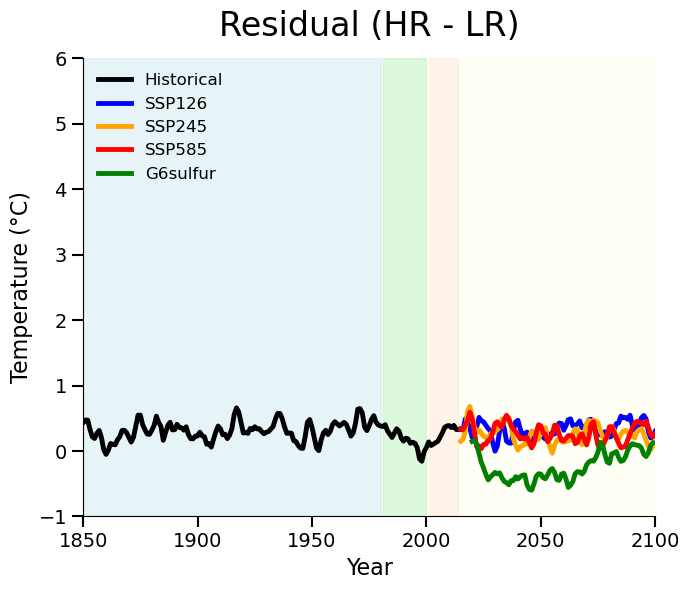

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for shading
shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variables
var_hr = 'tas_hr'
var_lr = 'tas_lr_interp'

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Colors for scenarios
colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'green'
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

# Reorder scenarios so G6sulfur is last
scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('ssp585', ds_ssp585),
    ('g6sulfur', ds_g6sulfur)
]

for scenario_name, ds in scenarios:
    # Get HR and LR temperature data
    tas_hr_data = ds[var_hr].values
    tas_lr_data = ds[var_lr].values
    years = ds.time.dt.year.values
    
    # Calculate residual (HR - LR)
    residual_data = tas_hr_data - tas_lr_data
    
    # Calculate global mean residual
    global_mean_residual = np.mean(residual_data, axis=(1, 2))
    
    # Convert to annual averages
    annual_years, annual_mean = to_annual_mean(global_mean_residual, years)
    
    # Apply smoothing
    window = 3
    smoothed = smooth_data(annual_mean, window)
    
    color = colors[scenario_name]
    
    # Plot residual
    ax.plot(annual_years, smoothed, color=color,
            linewidth=3.5, alpha=1, label=labels[scenario_name])

# Add shading
for start_year, end_year, color_shade, alpha in shade_periods:
    ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)

# Set limits and ticks
ax.set_ylim(-1, 6)
ax.set_yticks(np.arange(-1, 7, 1))
ax.set_xlim(1850, 2100)
ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100])

# Labels
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_title('Residual (HR - LR)', fontsize=24, pad=16)

# Legend
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick parameters
ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_04.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

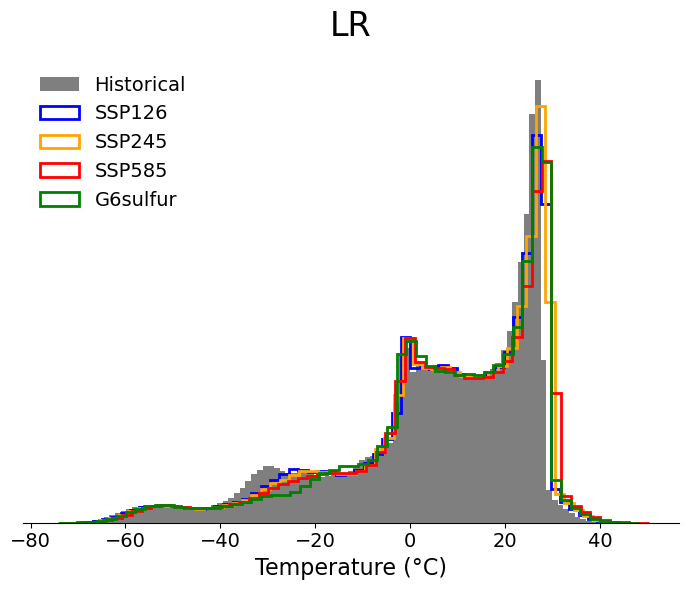

In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
data_dir = "../data"
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Original datasets
ds_hist = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_g6 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")
ds_ssp585 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")

# Training period
train_start = '1850'
train_end = '1980'

# Prepare data
scenarios_raw = {
    'Historical': ds_hist['tas_lr_interp'].sel(time=slice(train_start, train_end)),
    'SSP126': ds_ssp126['tas_lr_interp'],
    'SSP245': ds_ssp245['tas_lr_interp'],
    'G6sulfur': ds_g6['tas_lr_interp'],
    'SSP585': ds_ssp585['tas_lr_interp']
}

# Colors for scenarios
colors = {
    'Historical': 'black',
    'SSP126': 'blue',
    'SSP245': 'orange',
    'G6sulfur': 'green',
    'SSP585': 'red'
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot Historical first with filled bars
data = scenarios_raw['Historical']
vals = data.values.ravel()
vals = vals[np.isfinite(vals)]
ax.hist(vals, bins=100, density=True, alpha=0.5, color=colors['Historical'], 
        label='Historical', edgecolor='none')

# Plot other scenarios as histogram outlines (step)
for name in ['SSP126', 'SSP245', 'SSP585', 'G6sulfur']:
    data = scenarios_raw[name]
    vals = data.values.ravel()
    vals = vals[np.isfinite(vals)]
    ax.hist(vals, bins=60, density=True, histtype='step', linewidth=2,
            label=name, color=colors[name])

# Remove y-axis
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels
ax.set_xlabel('Temperature (°C)', fontsize=16)
ax.set_title('LR', fontsize=24, pad=16)

# Legend
ax.legend(frameon=False, fontsize=14, loc='upper left')

# Tick parameters
ax.tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_05.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

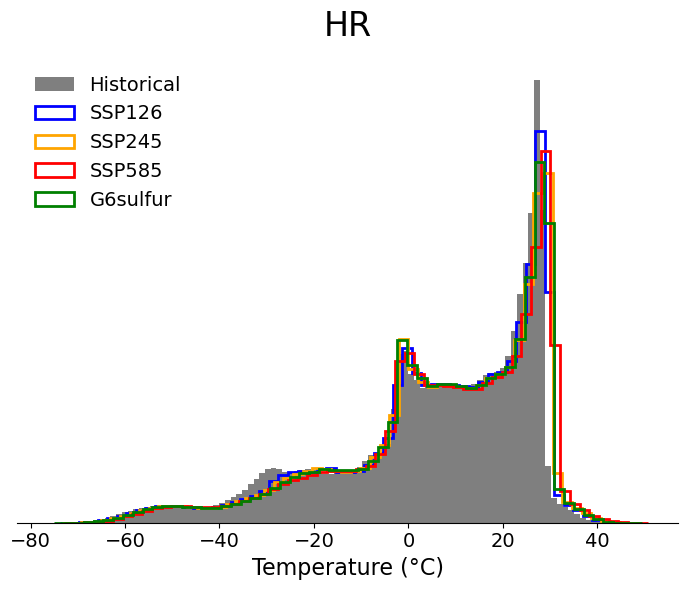

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
data_dir = "../data"
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Original datasets
ds_hist = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_g6 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")
ds_ssp585 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")

# Training period
train_start = '1850'
train_end = '1980'

# Prepare data - using HR instead of LR
scenarios_raw = {
    'Historical': ds_hist['tas_hr'].sel(time=slice(train_start, train_end)),
    'SSP126': ds_ssp126['tas_hr'],
    'SSP245': ds_ssp245['tas_hr'],
    'G6sulfur': ds_g6['tas_hr'],
    'SSP585': ds_ssp585['tas_hr']
}

# Colors for scenarios
colors = {
    'Historical': 'black',
    'SSP126': 'blue',
    'SSP245': 'orange',
    'G6sulfur': 'green',
    'SSP585': 'red'
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot Historical first with filled bars
data = scenarios_raw['Historical']
vals = data.values.ravel()
vals = vals[np.isfinite(vals)]
ax.hist(vals, bins=100, density=True, alpha=0.5, color=colors['Historical'], 
        label='Historical', edgecolor='none')

# Plot other scenarios as histogram outlines (step)
for name in ['SSP126', 'SSP245', 'SSP585', 'G6sulfur']:
    data = scenarios_raw[name]
    vals = data.values.ravel()
    vals = vals[np.isfinite(vals)]
    ax.hist(vals, bins=60, density=True, histtype='step', linewidth=2,
            label=name, color=colors[name])

# Remove y-axis
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels
ax.set_xlabel('Temperature (°C)', fontsize=16)
ax.set_title('HR', fontsize=24, pad=16)

# Legend
ax.legend(frameon=False, fontsize=14, loc='upper left')

# Tick parameters
ax.tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_06.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

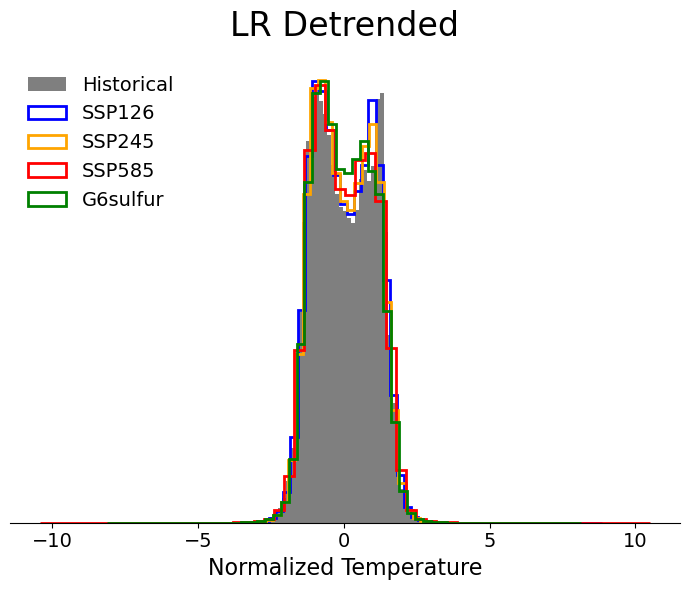

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

# Load data
data_dir = "../data"
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Detrended datasets
ds_hist_detrend = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_historical_residual_detrended.nc")
ds_ssp126_detrend = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp126_residual_detrended.nc")
ds_ssp245_detrend = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp245_residual_detrended.nc")
ds_g6_detrend = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_g6sulfur_residual_detrended.nc")
ds_ssp585_detrend = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp585_residual_detrended.nc")

# Load detrended normalization statistics
with open(f"{data_dir}/norm_stats_zscore_pixel_residual_detrended.pkl", 'rb') as f:
    norm_stats_detrend = pickle.load(f)

# Training period
train_start = '1850'
train_end = '1980'

# Prepare PLD data
scenarios_pld = {
    'Historical': ds_hist_detrend['tas_lr_detrend_grid'].sel(time=slice(train_start, train_end)),
    'SSP126': ds_ssp126_detrend['tas_lr_detrend_grid'],
    'SSP245': ds_ssp245_detrend['tas_lr_detrend_grid'],
    'G6sulfur': ds_g6_detrend['tas_lr_detrend_grid'],
    'SSP585': ds_ssp585_detrend['tas_lr_detrend_grid']
}

# Apply normalization
scenarios_pld_norm = {}
for name, data in scenarios_pld.items():
    data_mean = norm_stats_detrend['tas']['lr_detrend_grid']['pixel_mean']
    data_std = norm_stats_detrend['tas']['lr_detrend_grid']['pixel_std']
    scenarios_pld_norm[name] = (data - data_mean) / (data_std + 1e-8)

# Colors for scenarios
colors = {
    'Historical': 'black',
    'SSP126': 'blue',
    'SSP245': 'orange',
    'G6sulfur': 'green',
    'SSP585': 'red'
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot Historical first with filled bars
data = scenarios_pld_norm['Historical']
vals = data.values.ravel()
vals = vals[np.isfinite(vals)]
ax.hist(vals, bins=100, density=True, alpha=0.5, color=colors['Historical'], 
        label='Historical', edgecolor='none')

# Plot other scenarios as histogram outlines (step)
for name in ['SSP126', 'SSP245', 'SSP585', 'G6sulfur']:
    data = scenarios_pld_norm[name]
    vals = data.values.ravel()
    vals = vals[np.isfinite(vals)]
    ax.hist(vals, bins=60, density=True, histtype='step', linewidth=2,
            label=name, color=colors[name])

# Remove y-axis
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels
ax.set_xlabel('Normalized Temperature', fontsize=16)
ax.set_title('LR Detrended', fontsize=24, pad=16)

# Legend
ax.legend(frameon=False, fontsize=14, loc='upper left')

# Tick parameters
ax.tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_07.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

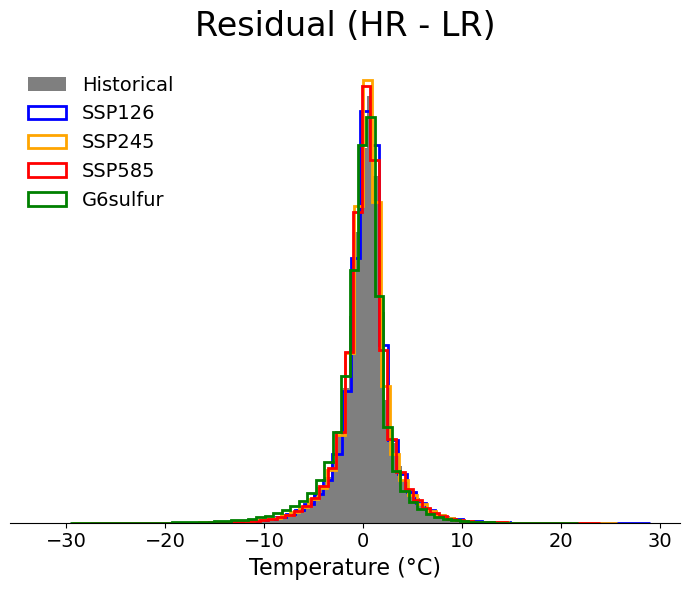

In [30]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
data_dir = "../data"
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Original datasets
ds_hist = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_g6 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")
ds_ssp585 = xr.open_dataset(f"{data_dir}/MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")

# Training period
train_start = '1850'
train_end = '1980'

# Calculate residuals (HR - LR) for each scenario
scenarios_residual = {
    'Historical': (ds_hist['tas_hr'] - ds_hist['tas_lr_interp']).sel(time=slice(train_start, train_end)),
    'SSP126': ds_ssp126['tas_hr'] - ds_ssp126['tas_lr_interp'],
    'SSP245': ds_ssp245['tas_hr'] - ds_ssp245['tas_lr_interp'],
    'G6sulfur': ds_g6['tas_hr'] - ds_g6['tas_lr_interp'],
    'SSP585': ds_ssp585['tas_hr'] - ds_ssp585['tas_lr_interp']
}

# Colors for scenarios
colors = {
    'Historical': 'black',
    'SSP126': 'blue',
    'SSP245': 'orange',
    'G6sulfur': 'green',
    'SSP585': 'red'
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot Historical first with filled bars
data = scenarios_residual['Historical']
vals = data.values.ravel()
vals = vals[np.isfinite(vals)]
ax.hist(vals, bins=100, density=True, alpha=0.5, color=colors['Historical'], 
        label='Historical', edgecolor='none')

# Plot other scenarios as histogram outlines (step)
for name in ['SSP126', 'SSP245', 'SSP585', 'G6sulfur']:
    data = scenarios_residual[name]
    vals = data.values.ravel()
    vals = vals[np.isfinite(vals)]
    ax.hist(vals, bins=60, density=True, histtype='step', linewidth=2,
            label=name, color=colors[name])

# Remove y-axis
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels
ax.set_xlabel('Temperature (°C)', fontsize=16)
ax.set_title('Residual (HR - LR)', fontsize=24, pad=16)

# Legend
ax.legend(frameon=False, fontsize=14, loc='upper left')

# Tick parameters
ax.tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()

# Save figure
output_file = figures_dir / "fig1_08.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()